In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import xgboost as xgb
import lightgbm as lgb
import scipy as sp

from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, AdaBoostRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

# 데이터 가져오기
https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr

In [2]:
data_dir = os.getenv('HOME') + '/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [3]:
train.head(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.0,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.0,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.0,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
test.head(3)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930


In [5]:
cols = train.columns
cols

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

<br><br><br><br><br><br>

# 1. 데이터 탐색 및 전처리

## 1-1. 결측값 확인

In [6]:
train.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## 1-2. id 중복체크

In [7]:
# id_duplicated = train[train.duplicated(['id'])]
print(len(train['id']))
print(len(pd.value_counts(train['id'])))

15035
15035


## 1-3. 목적변수(price) 정규분포
- np.log1p(y) : 로그함수로 변환  
- np.expm1(y) : 각 원소x마다 exp(x)-1을 반환  

우선 로그변환을 해준 후 모델이 값을 예측한 후에 다시 np.expm1()을 통해 되돌림

<AxesSubplot:xlabel='price', ylabel='Density'>

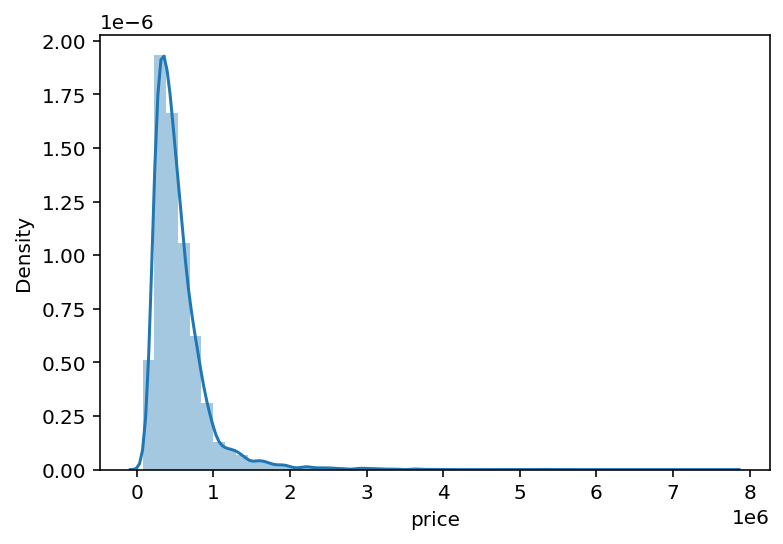

In [8]:
# price 분포 확인
fig, ax = plt.subplots(figsize=(6,4))
sns.distplot(train['price'])

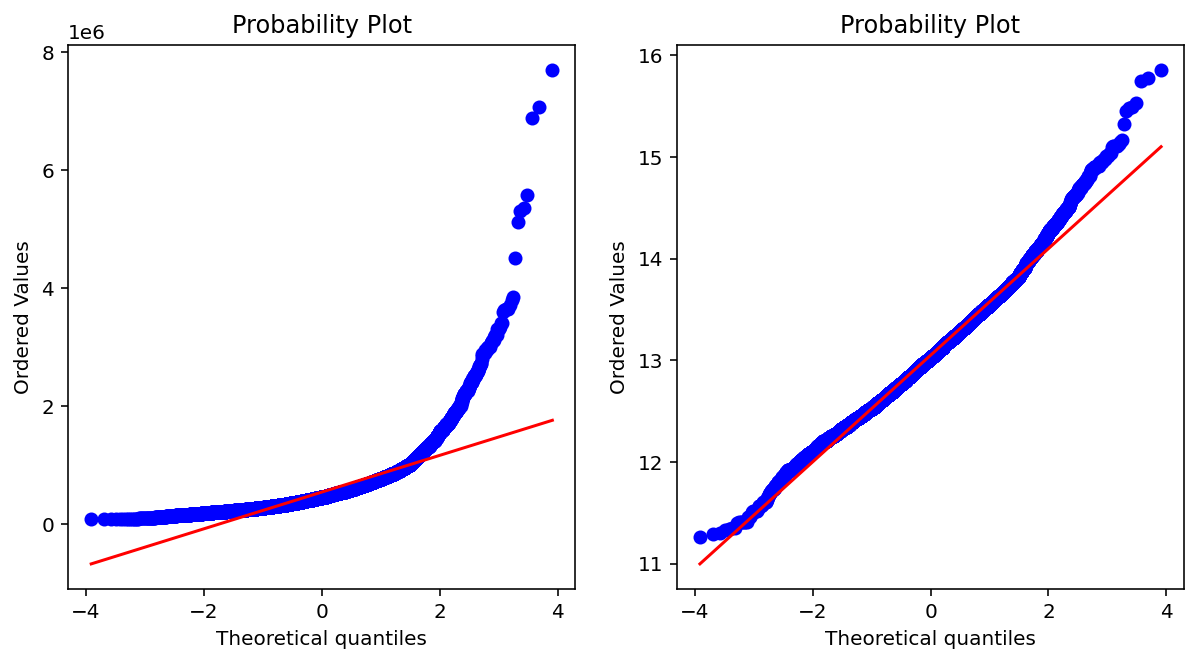

In [9]:
# log를 취해줬을 때 정규성 확인
fig = plt.figure(figsize = (10,5))

fig.add_subplot(1,2,1)
res = sp.stats.probplot(train['price'], plot=plt)

fig.add_subplot(1,2,2)
res = sp.stats.probplot(np.log1p(train['price']), plot=plt)

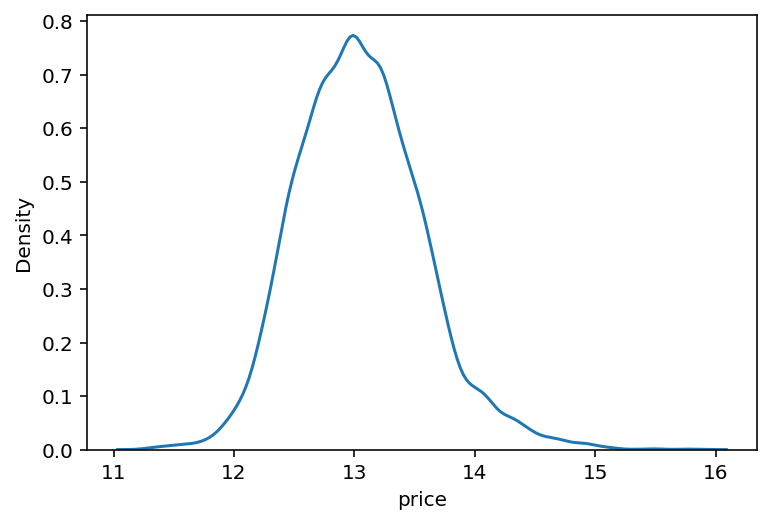

In [10]:
# 목적변수 정규분포
train['price'] = np.log1p(train['price'])
sns.kdeplot(train['price'])
plt.show()

## 1-4. 변수시각화(반응변수)

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

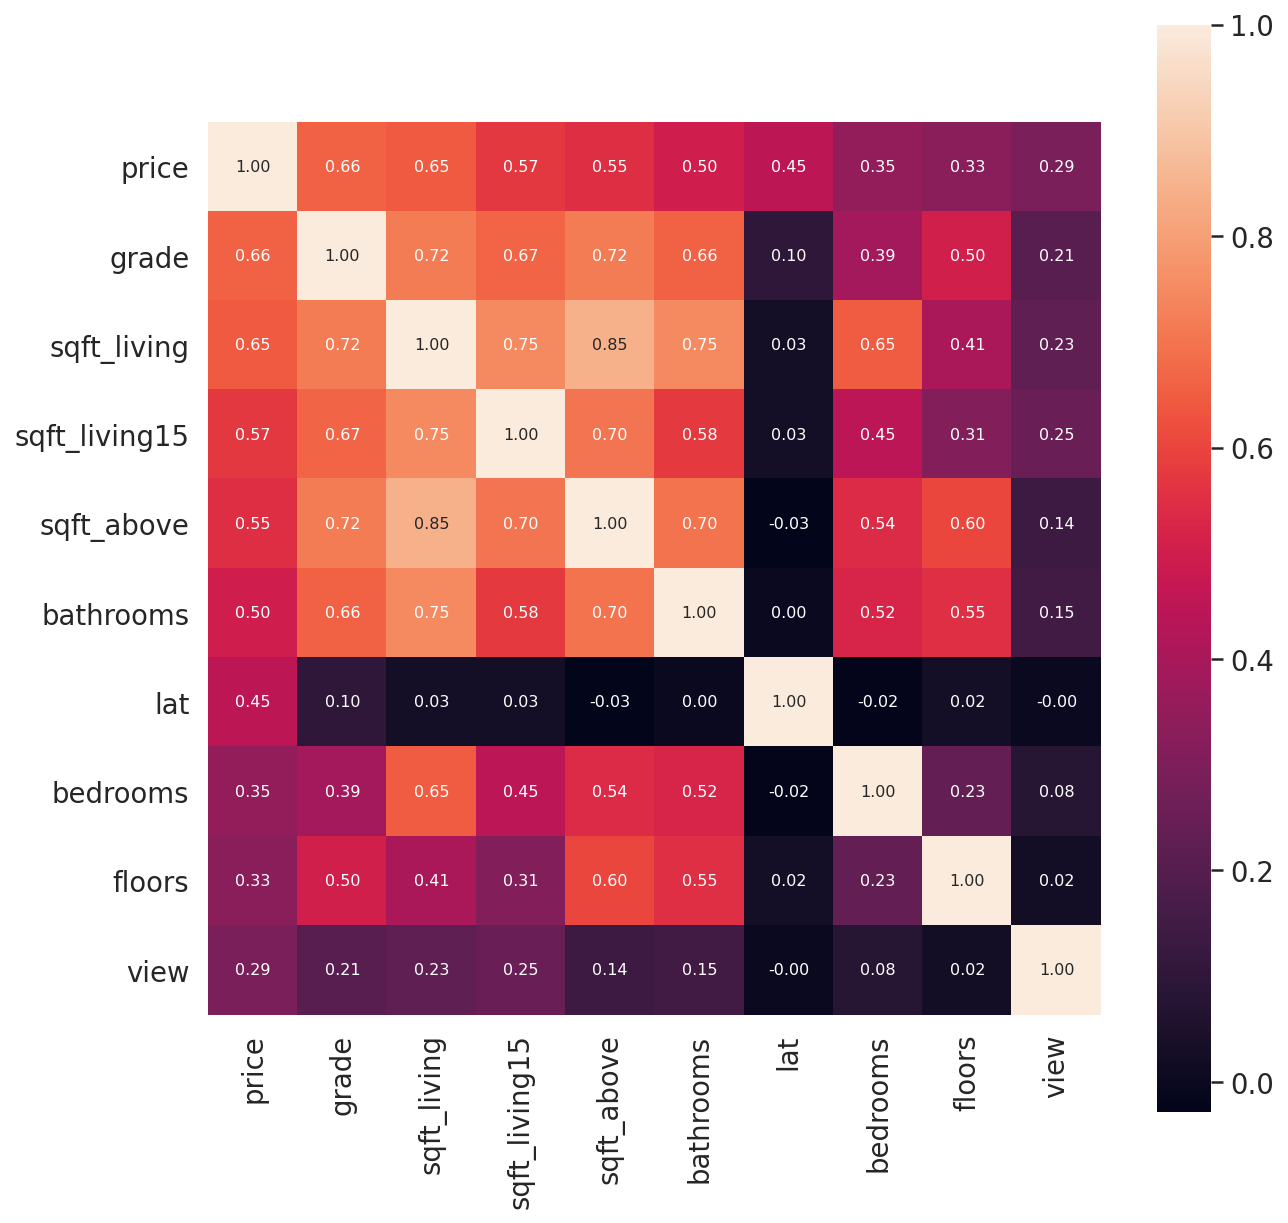

In [11]:
cor_abs = abs(train.corr(method='spearman'))
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

## 1-5. grade 이상치 제거
- grade : King County grading 시스템 기준으로 매긴 집의 등급
- grade가 높을수록 price도 증가하고 있다.  
- min과 max를 벗어난 이상치가 확인되고 있다.

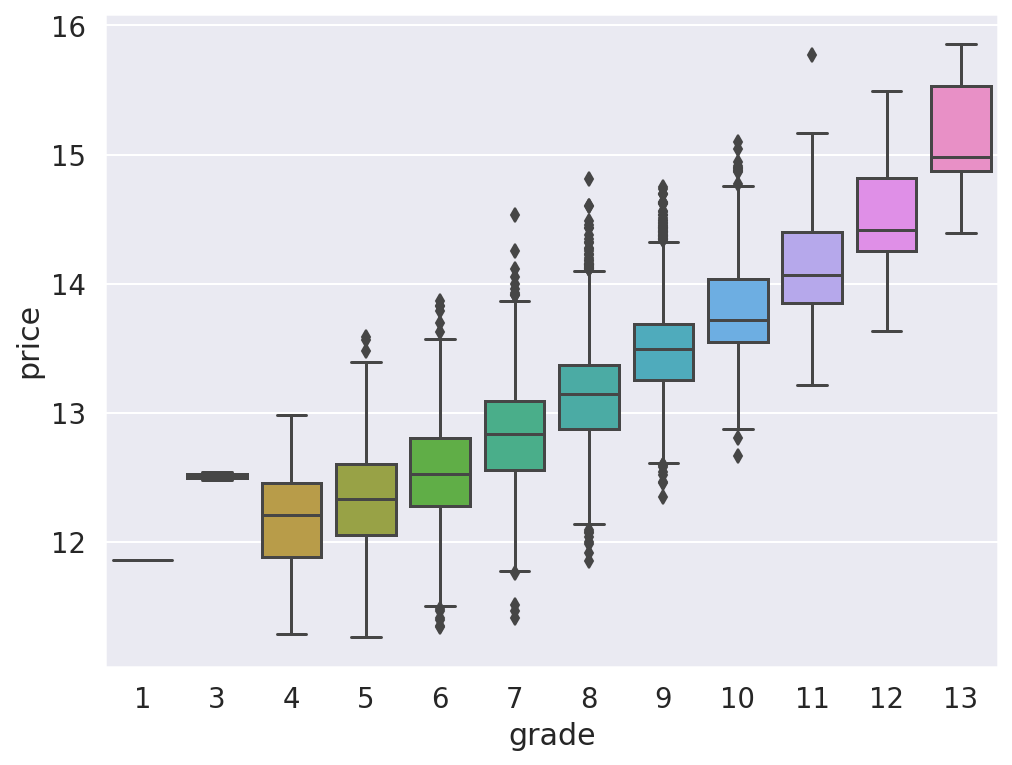

In [12]:
data = pd.concat([train['price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y='price', data = data)

In [13]:
train.loc[(train['grade'] == 3) & (train['price'] > 12)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,20150225T000000,12.476104,1,0.75,520,12981,1.0,0,0,...,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,20141104T000000,12.542548,1,0.00,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


In [14]:
train.loc[(train['grade'] == 7) & (train['price'] > 14.5)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
12346,12346,20150115T000000,14.533351,4,3.25,3580,19989,1.5,1,4,...,7,3480,100,1915,1965,98125,47.7087,-122.276,2410,6389


In [15]:
train.loc[(train['grade'] == 8) & (train['price'] > 14.7)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,7173,20140813T000000,14.808763,5,4.0,4230,27295,2.0,1,4,...,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


In [16]:
train.loc[(train['grade'] == 11) & (train['price'] > 15.5)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611T000000,15.77031,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


In [17]:
def outlier(df, col, n, d_col='price'):
    data = df[df[col] == n]
    q3, q1 = np.percentile(data[d_col], [75, 25])
    iqr = q3 - q1
    return data[(q1 - 1.5 * iqr > data[d_col]) | (q3 +1.5 * iqr < data[d_col]) ]

# outlier(train, 'grade', 7).sort_values(by='price', ascending=False)

가장 중요한 변수인 grade, sqft_ 모두 낮은 것을 보아 모두 이상치로 규정하고 제거.

In [18]:
train = train.loc[train['id'] != 2302]
train = train.loc[train['id'] != 4123]
train = train.loc[train['id'] != 12346]
train = train.loc[train['id'] != 7173]
train = train.loc[train['id'] != 2775]
print(len(train['id']))

15030


## 1-6. sqft_living 이상치 제거
- sqft_living : 주거 공간의 평방 피트(면적)
- 전체적으로 크기가 커지면 가격이 오르는 것을 볼 수 있다.
- 하지만 14000일때 가격이 비교적 아래에 있는 것을 보아 이상치로 확인된다.

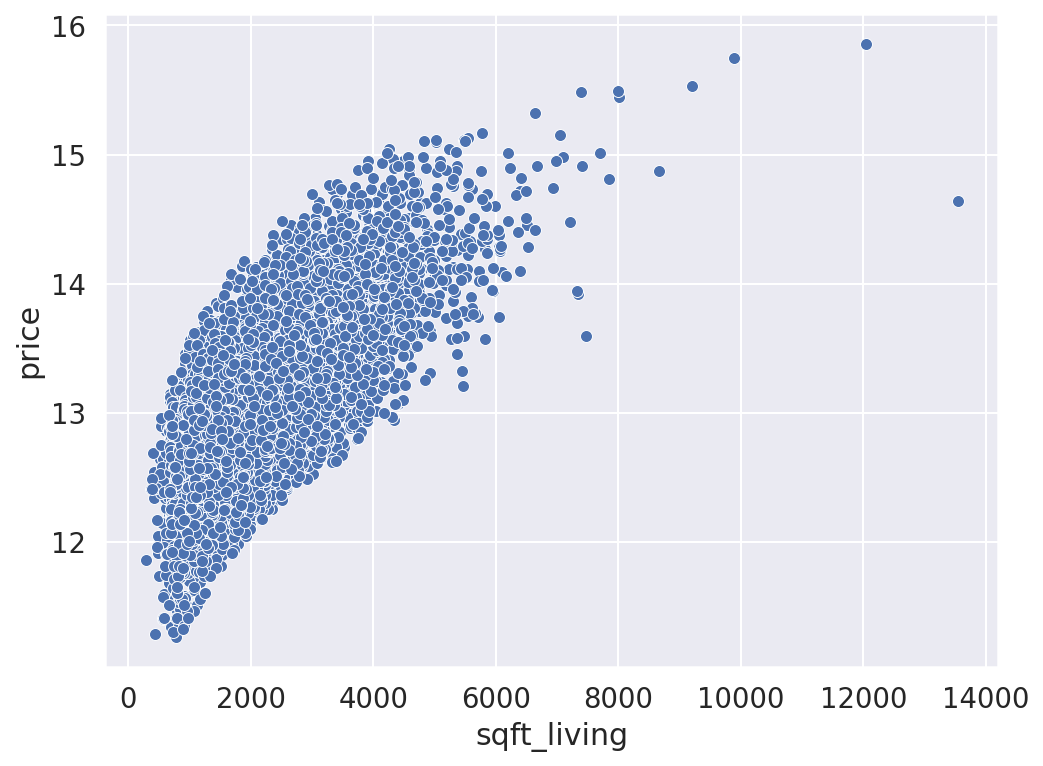

In [19]:
data = pd.concat([train['price'], train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.scatterplot(x='sqft_living', y='price', data = data)

In [20]:
train.loc[train['sqft_living']>13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,20140505T000000,14.639686,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


price와 상관성이 높은 grade와도 큰 의미가 없으므로 제거

In [21]:
train = train.loc[train['id'] != 8912]
print(len(train['id']))

15029


## 1-7. sqft_above
- sqft_above : 지하실을 제외한 평방 피트(면적)

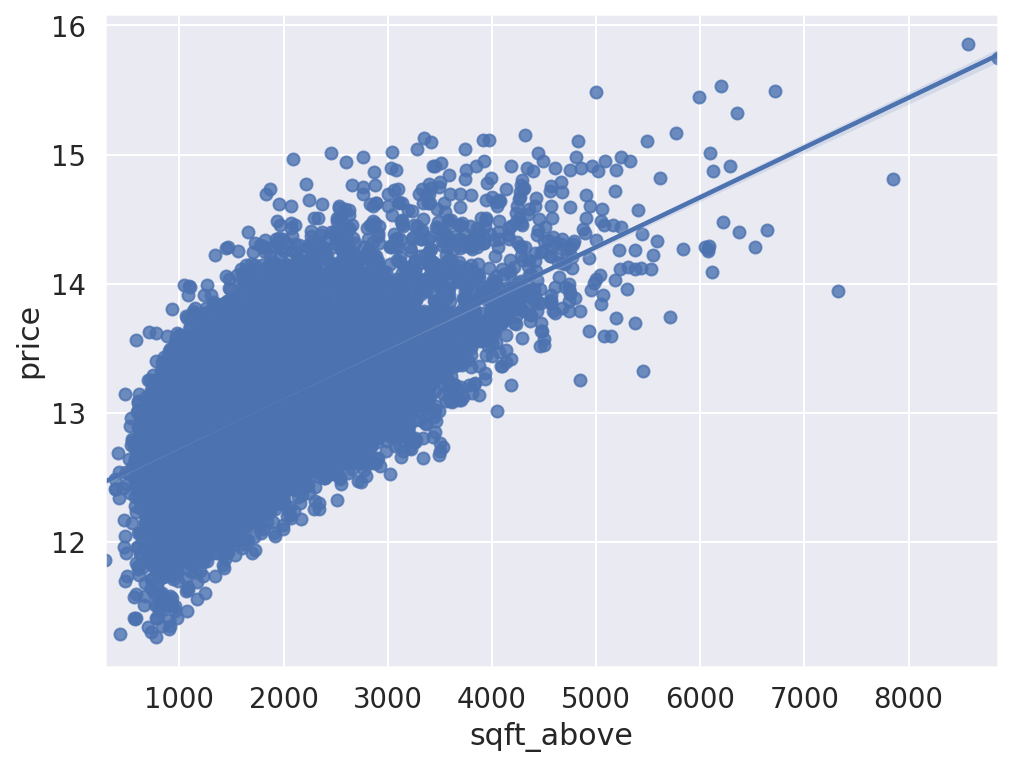

In [22]:
data = pd.concat([train['price'], train['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_above', y='price', data = data)

## 1-8. bathrooms
- bathrooms : 화장실의 수  

- 0.5 : 세면대, 화장실
- 0.75 : 세면대, 화장실, 샤워실
- 1 : 세면대, 화장실, 샤워실, 욕조

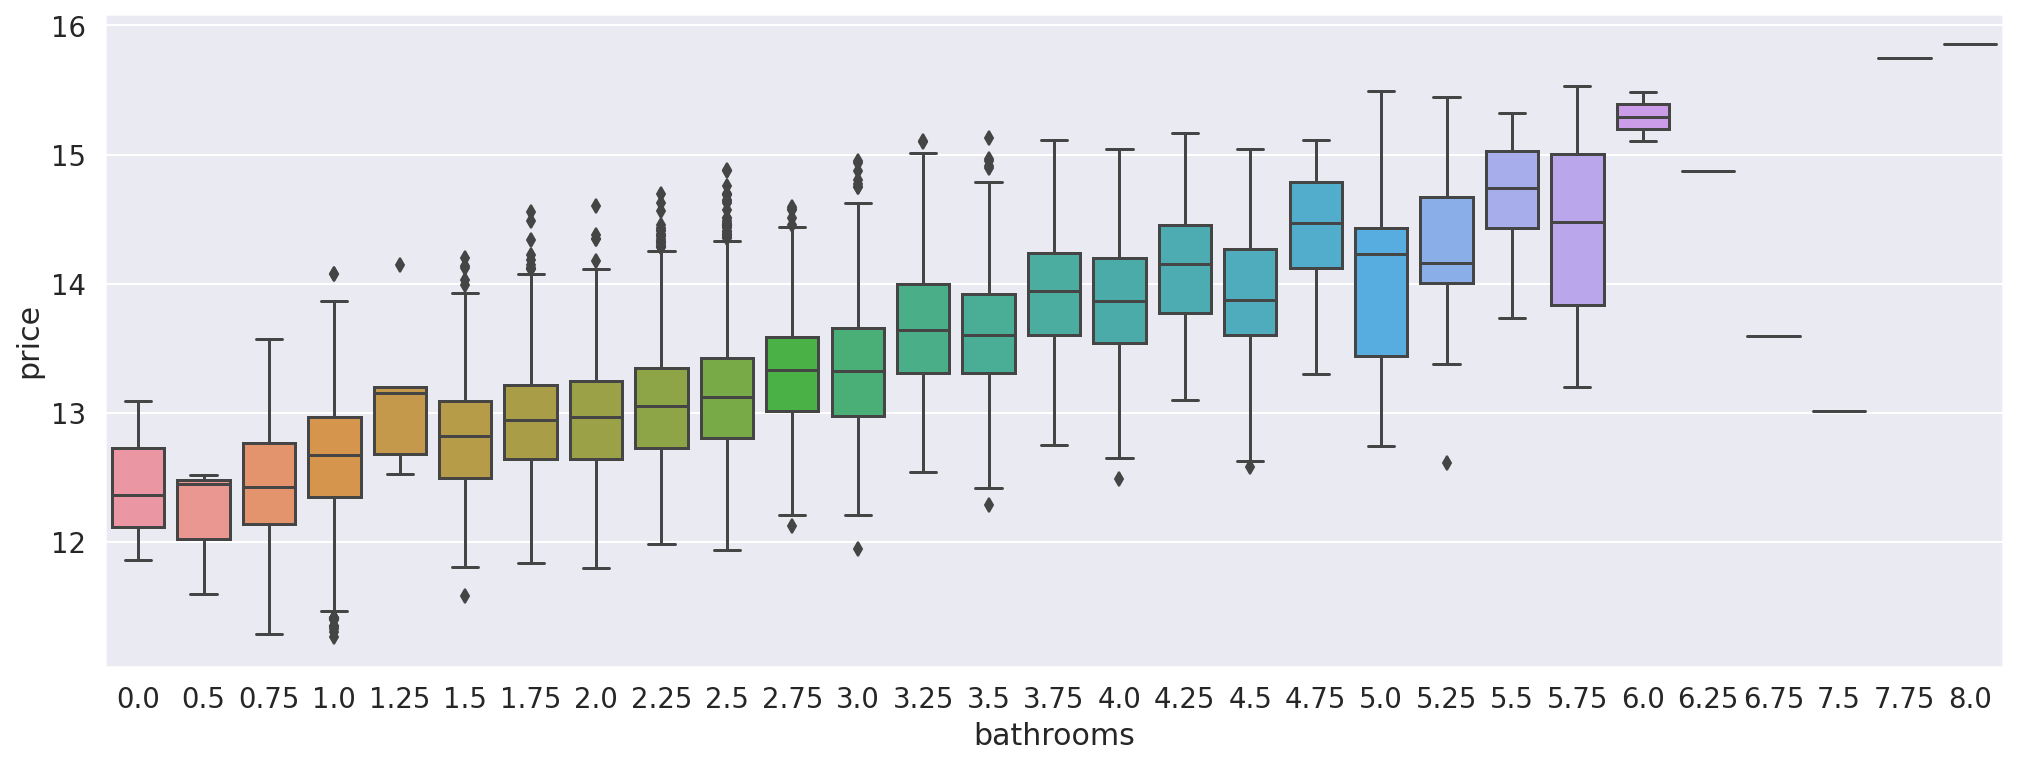

In [23]:
data = pd.concat([train['price'], train['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(17, 6))
fig = sns.boxplot(x='bathrooms', y='price', data = data)

## 1-9. lat 위도
- 위도 47.5 ~ 47.8에 위치하는 집이 가격이 높은 것을 볼 수 있다.

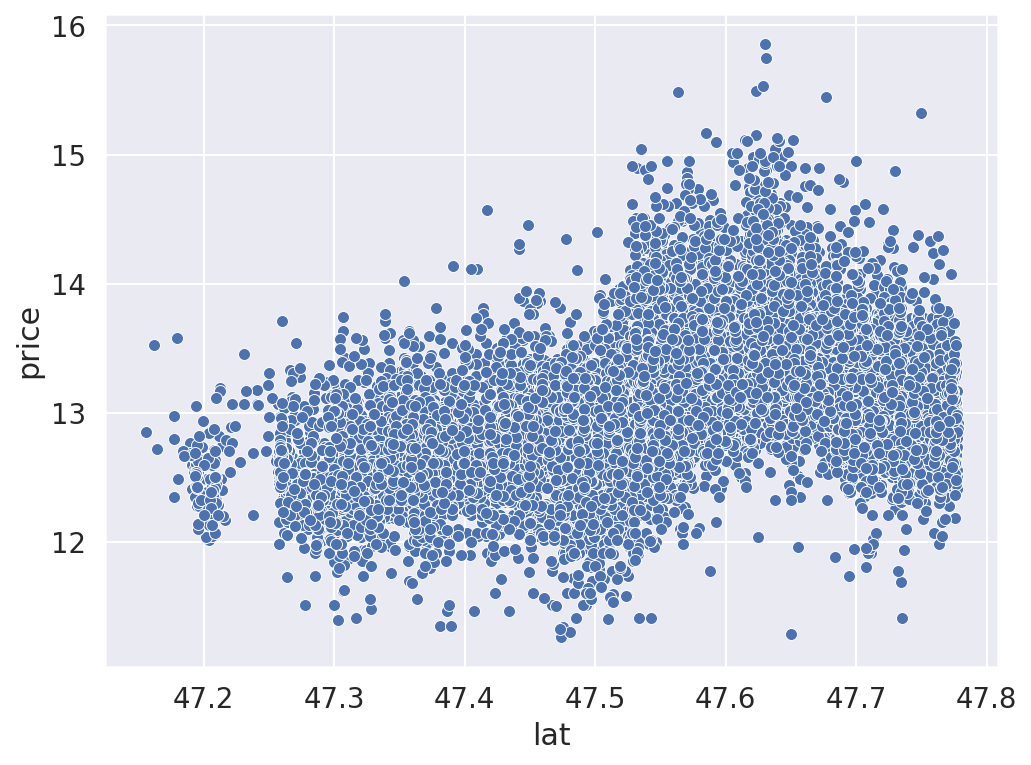

In [24]:
data = pd.concat([train['price'], train['lat']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.scatterplot(x='lat', y='price', data = data)

## 1-10. date 형태 변환
before : 20141013T000000  
after : 20141013

In [25]:
train['date'] = train['date'].apply(lambda i: i[:8]).astype(int)
test['date'] = test['date'].apply(lambda i: i[:8]).astype(int)

## 1-11. floors, waterfront, condition

In [26]:
print(train['waterfront'].unique())
print(train['view'].unique())
print(train['condition'].unique())

[0 1]
[0 3 4 2 1]
[3 4 5 2 1]


## 1-12. id 삭제
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거

In [27]:
del train['id']
del test['id']

## 1-13. 정규화

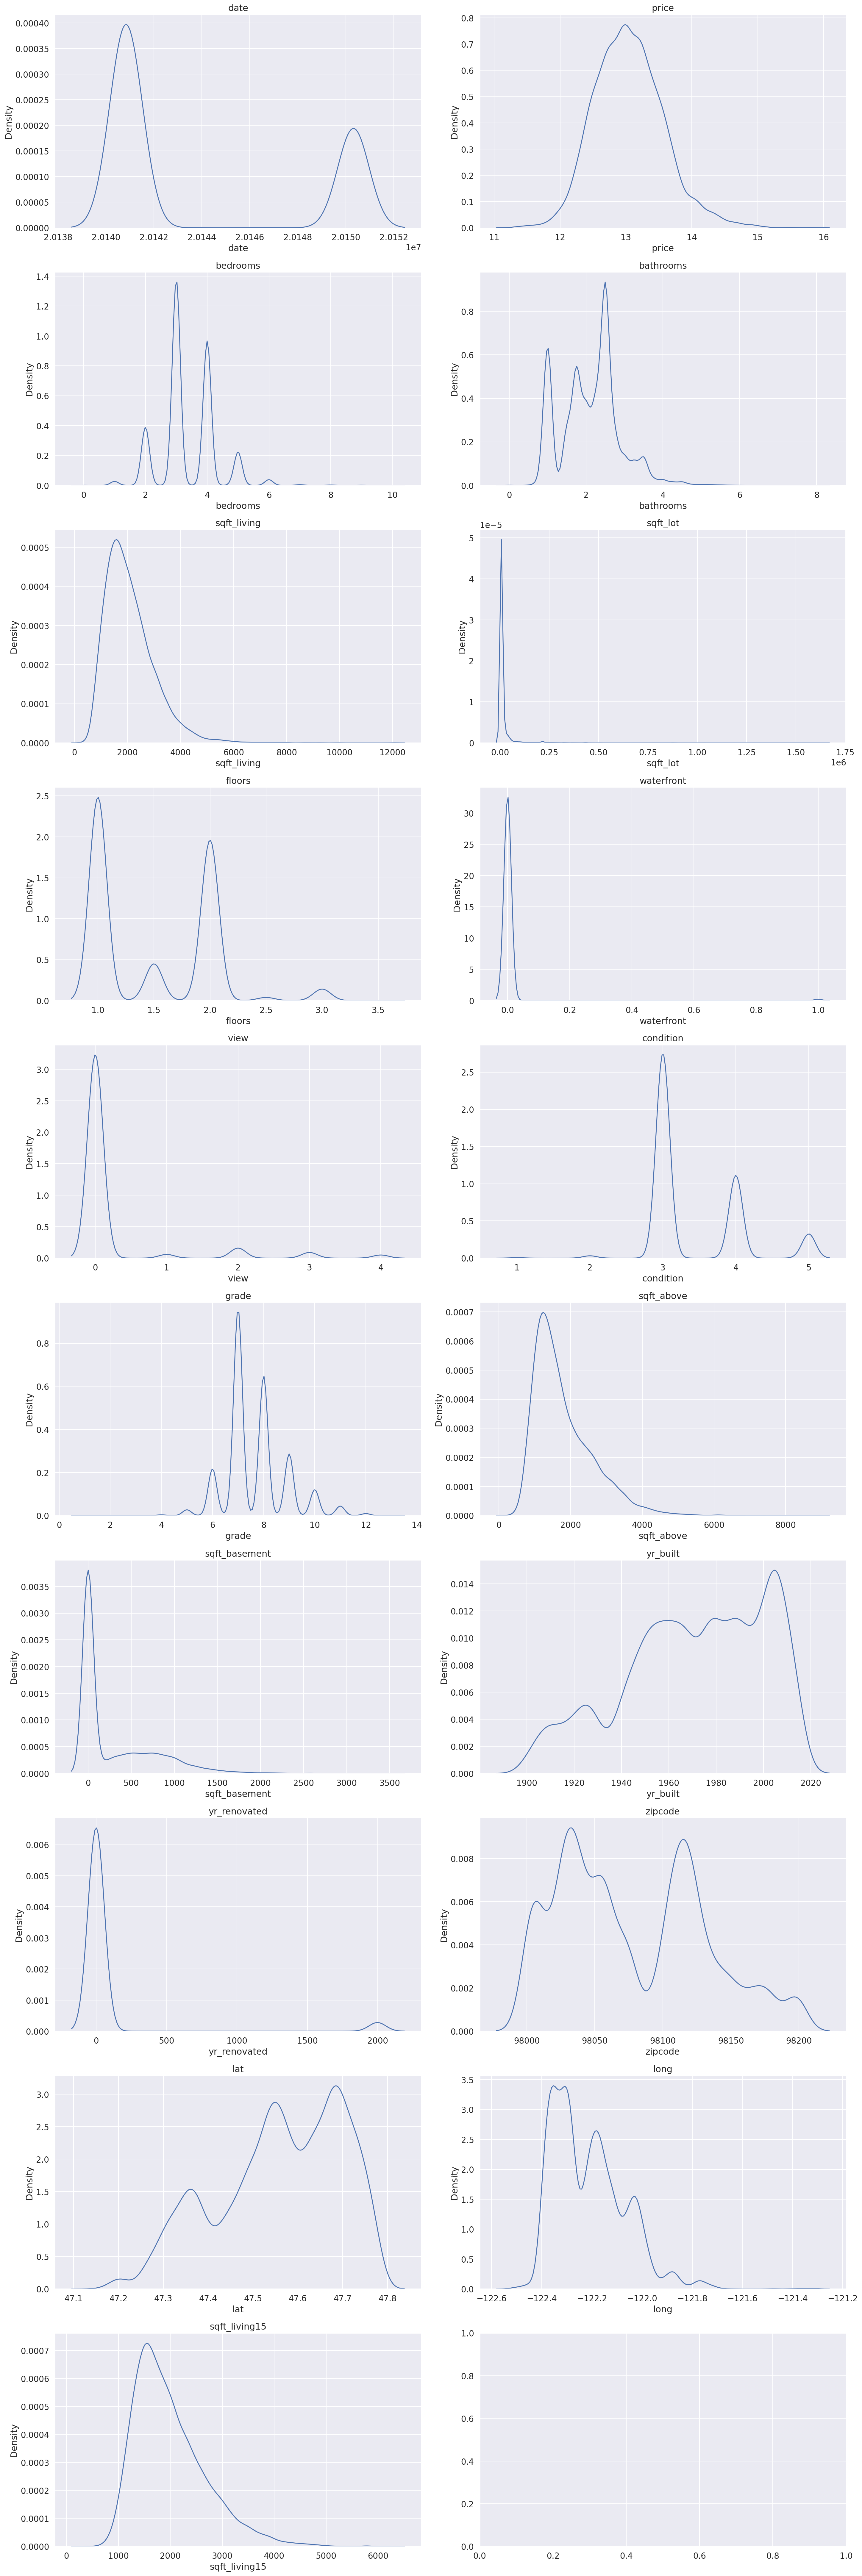

In [28]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60), constrained_layout=True)
columns = train.columns
count = 0
for row in range(10):
    for col in range(2):
        sns.kdeplot(train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

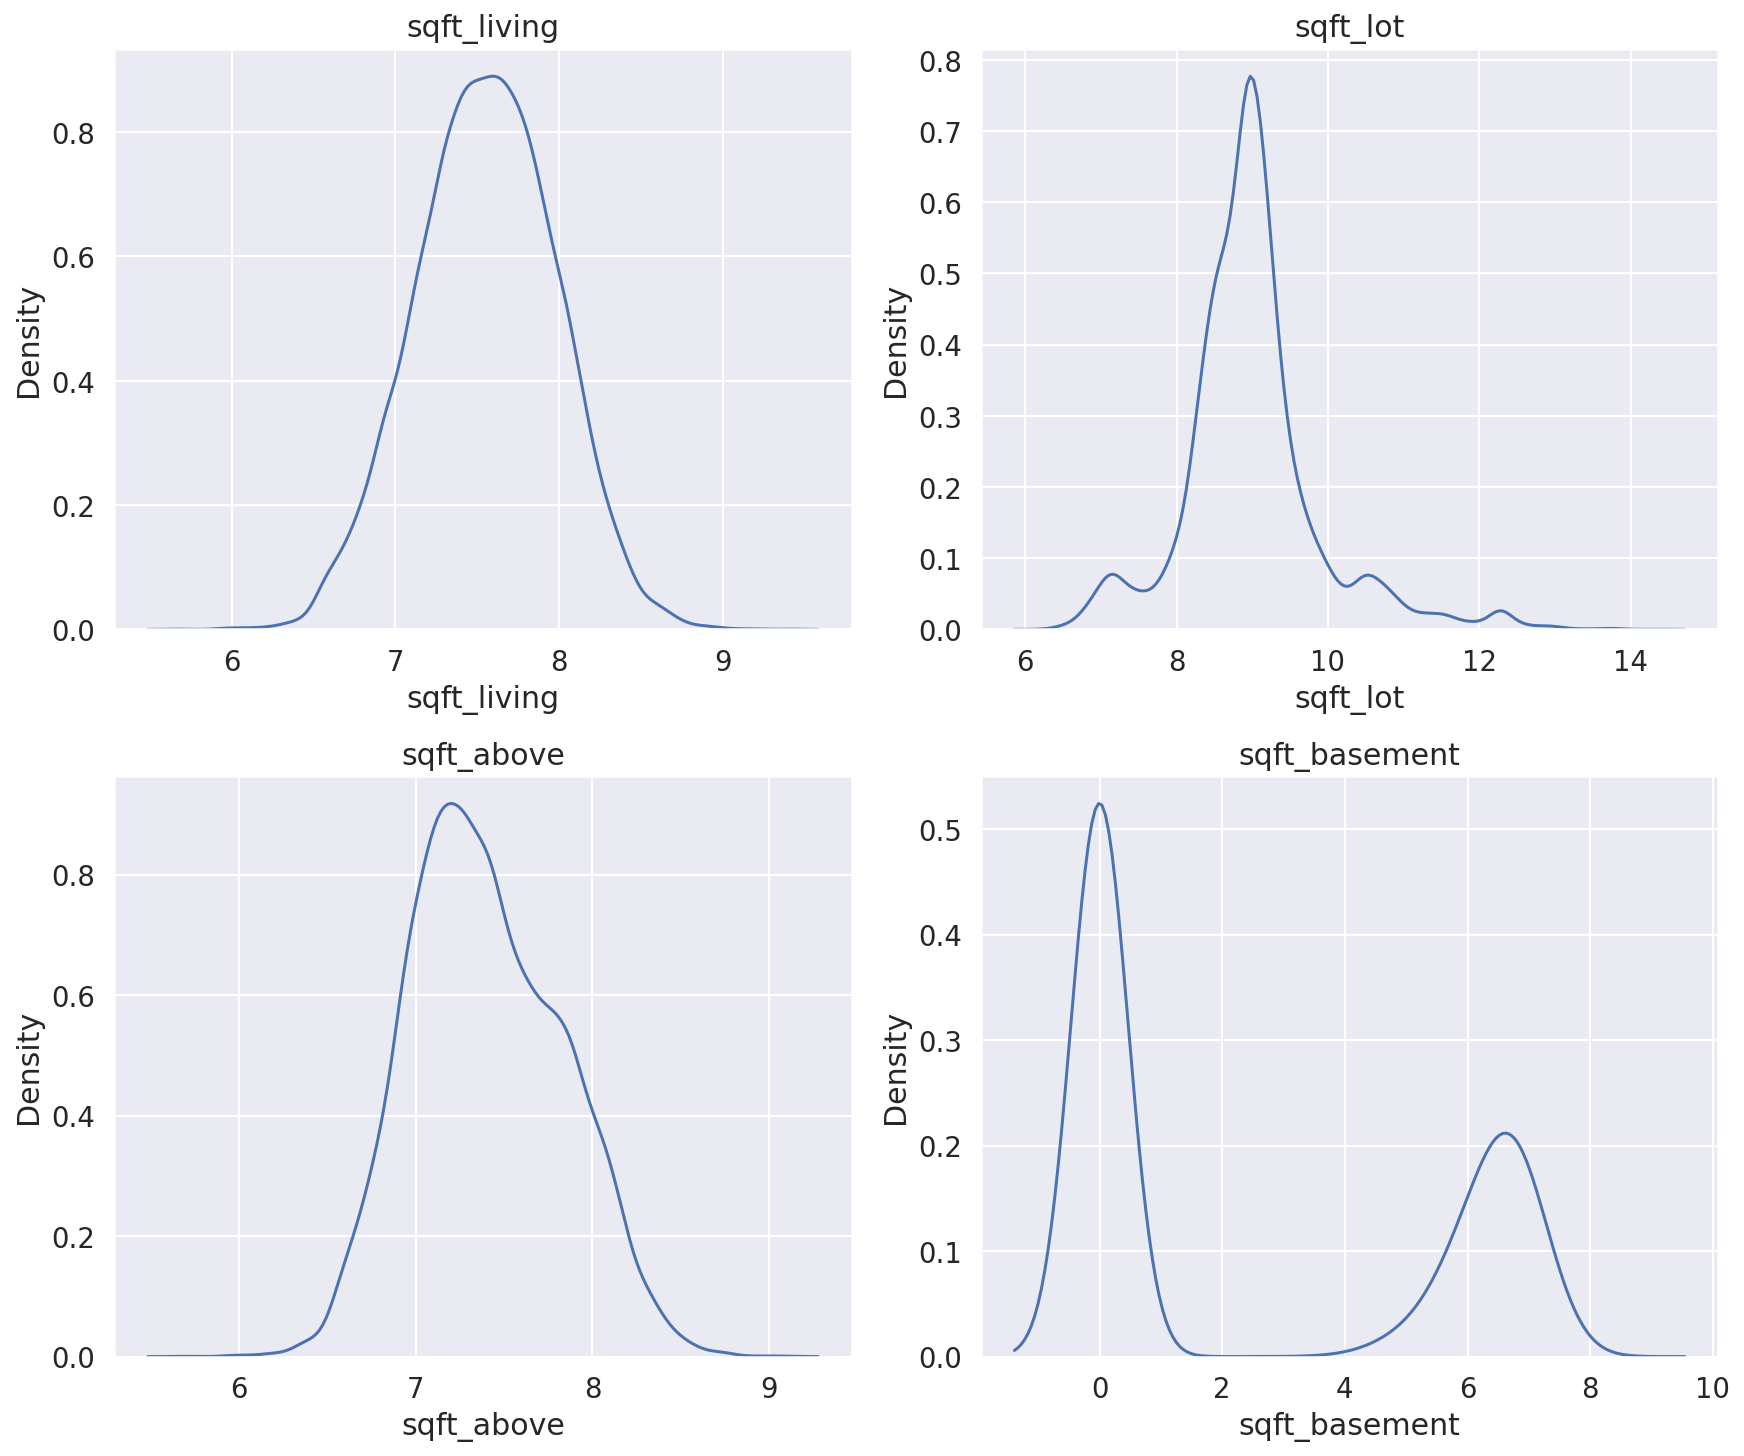

In [29]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)

fig, ax = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)

count = 0
for row in range(2):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

## 1-14. 타겟 데이터인 price컬럼 분리

In [30]:
y = train['price']
del train['price']

## 1-15. 자료형 확인
모두 실수 or 정수자료형이므로 모델 학습 활용 가능

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15029 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15029 non-null  int64  
 1   bedrooms       15029 non-null  int64  
 2   bathrooms      15029 non-null  float64
 3   sqft_living    15029 non-null  float64
 4   sqft_lot       15029 non-null  float64
 5   floors         15029 non-null  float64
 6   waterfront     15029 non-null  int64  
 7   view           15029 non-null  int64  
 8   condition      15029 non-null  int64  
 9   grade          15029 non-null  int64  
 10  sqft_above     15029 non-null  float64
 11  sqft_basement  15029 non-null  float64
 12  yr_built       15029 non-null  int64  
 13  yr_renovated   15029 non-null  int64  
 14  zipcode        15029 non-null  int64  
 15  lat            15029 non-null  float64
 16  long           15029 non-null  float64
 17  sqft_living15  15029 non-null  int64  
 18  sqft_l

<br><br><br><br><br><br><br><br>

# 2. 모델별 스코어

## 2-1. RMSE
기존에 y를 로그함수로 변환해주었기 때문에 mean_squared_error에 값을 넘기기 전,  
np.expm1으로 다시 변환해서 넘겨준다.

In [32]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

## 2-2. 모델별 학습 및 예측

In [33]:
def get_scores(models, train, y):
    df = {}
    for model in models:
        # 모델이름 획득
        model_name = model.__class__.__name__
        # train, test 데이터셋 분리 - 여기에도 random_state를 고정
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        # 학습
        model.fit(X_train, y_train)
        # 예측
        y_pred = model.predict(X_test)
        # 예측결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return score_df

## Model
- random_state
  - 모델 초기화나 데이터셋 구성에 사용되는 랜덤 시드값
  - 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택
  - None일 때, 파라미터 초기화나 데이터셋 구성 양상이 달라져 모델과 데이터셋이 동일하더라도 머신러닝 학습결과는 학습할 때마다 달라진다.
  - 어떤 시도가 모델 성능향상에 긍정적이였는지 판단하기 위해 랜덤적 요소의 변화때문에 생기는 불확실성을 제거해야 한다.
  - 따라서 특정값으로 고정시켜준다.

In [34]:
random_state = 2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,147802.081766
RandomForestRegressor,129145.079598
XGBRegressor,119677.014597
LGBMRegressor,118622.758451


<br><br><br><br><br><br><br><br>

# 3. 하이퍼파라미터 탐색

## 3-1. 그리드 탐색
**GridSearchCV 사용 (Grid Search)**
- param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
- scoring : 모델의 성능을 평가할 지표
- cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
- verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
- n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수

In [35]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model,
                              param_grid=param_grid,
                              scoring='neg_mean_squared_error',
                              cv=5,
                              verbose=verbose,
                              n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']          # 각 파라미터에 대한 조합
    score = grid_model.cv_results_['mean_test_score']  # 각 조합에 대한 점수

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])  # rmse: 평균제곱근오차
    results = results.rename(columns={'RMSE': 'RMSLE'})
    results = results.sort_values('RMSLE')  # `RMSLE`가 낮은 순서대로 정렬

    return results

- 각 파라미터에 대한 조합마다의 점수를 나타냄
- 왜 음수일까?  
  - scoring : 'neg_mean_squared_error'
  - neg_mean_squared_error : 평균 제곱 오차의 반댓값(음수)을 계산
  - 점수가 올라가면 좋다! (즉, 돈을 적게 잃어야 하는 것과 같다)

# 기존 : n_estimators, max_depth
param_grid = {
    'n_estimators': [100],
    'max_depth': [10, 20, 30, 40],
    'learning_rate': [0.01, 0.005],
    'num_iteration': [5000, 10000],
    'num_leaves': [10, 20, 30],
    'boosting': ['gbdt'],
    'min_data_in_leaf': [20, 100],
    'feature_fraction': [0.8, 0.9],
    'boosting': ['dart', 'gbdt']
}
model = LGBMRegressor(random_state=random_state)

my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

<br><br><br><br><br><br><br><br>

# 4. 학습 및 예측 결과 생성

In [36]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

GBoost = GradientBoostingRegressor(n_estimators=8000, learning_rate=0.05, max_depth=5,
                                   max_features='sqrt', min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state=4)

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=8000,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=31,
                              learning_rate=0.015, n_estimators=8000,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 1, feature_fraction = 0.9,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_child_samples = 20, reg_alpha= 0.1)

model_RF = RandomForestRegressor(max_depth = 8, 
                                n_estimators = 8000,
                                max_features = 'sqrt', 
                                n_jobs = -1)

models = [{'model':lasso, 'name':'LASSO'},
          {'model':ENet, 'name':'ENet'},
          {'model':GBoost, 'name':'GradientBoosting'},
          {'model':model_RF, 'name':'RandomForest'}, 
          {'model':model_xgb, 'name':'XGBoost'},
          {'model':model_lgb, 'name':'LightGBM'}]

In [37]:
# Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, train, y, scoring="neg_mean_squared_error", cv = kf))
    return (rmse)

In [38]:
for m in models:
    score = rmsle_cv(m['model'])
    print("Model {} CV score : {:.4f} ({:.4f})\n".format(m['name'], score.mean(), score.std()))

Model LASSO CV score : 0.2493 (0.0015)

Model ENet CV score : 0.2492 (0.0015)

Model GradientBoosting CV score : 0.1625 (0.0053)

Model RandomForest CV score : 0.2086 (0.0052)

[12:00:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:01:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:01:12] WARNING: /home/conda/feeds

In [39]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # base_models_는 2차원 배열입니다.
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    # 각 모델들의 평균값을 사용합니다.
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [40]:
stacked_averaged_models = StackingAveragedModels(
    base_models=(ENet, GBoost, model_RF, model_xgb, model_lgb),
    meta_model=(lasso)
)

In [41]:
#define a rmsle evaluation function
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [44]:
stacked_averaged_models.fit(train, y)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y, stacked_train_pred))

KeyError: "None of [Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,\n                9,\n            ...\n            15017, 15019, 15020, 15022, 15023, 15024, 15025, 15026, 15027,\n            15028],\n           dtype='int64', length=12023)] are in the [columns]"

In [ ]:
model_xgb.fit(train, y)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y, xgb_train_pred))

In [ ]:
GBoost.fit(train, y)
GBoost_train_pred  = GBoost.predict(train)
GBoost_pred = np.expm1(GBoost.predict(test))
print(rmsle(y, GBoost_train_pred))

In [ ]:
model_lgb.fit(train, y)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test))
print(rmsle(y, lgb_train_pred))

In [ ]:
sub = pd.DataFrame()
sub['id'] = test_id
sub['price'] = stacked_pred
sub.to_csv('submission_staking.csv',index=False)

In [ ]:
sub = pd.DataFrame()
sub['id'] = test_id
sub['price'] = xgb_pred
sub.to_csv('submission_xgb.csv',index=False)

In [ ]:
sub = pd.DataFrame()
sub['id'] = test_id
sub['price'] = GBoost_pred
sub.to_csv('submission_GBoost.csv',index=False)

In [ ]:
sub = pd.DataFrame()
sub['id'] = test_id
sub['price'] = lgb_pred
sub.to_csv('submission_lgb.csv',index=False)

In [ ]:
ensemble = stacked_pred*0.4 + xgb_pred*0.2 + GBoost_pred*0.2 + lgb_pred*0.2

In [ ]:
sub = pd.DataFrame()
sub['id'] = test_id
sub['price'] = ensemble
sub.to_csv('submission_ensemble.csv',index=False)

# csv에 쓰기

In [ ]:
def save_submission(model, train, y, test, model_name, rmsle):
    # 위에 나온 결과로 학습 및 예측 결과 생성
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    
    # csv에 쓰기
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [ ]:
# save_submission(model, train, y, test, 'lgbm', rmsle='0.1')